# Feed-Forward Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets

from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.io import renderers
renderers.default = 'png'
from plotly.subplots import make_subplots
import plotly.colors as plotly_colors

from utils.design import plotly_main_layout, plotly_main_subplot_layout

___
### MNIST

In [59]:
# Load MNIST (combine train and test to get 70,000 total)
train_set = datasets.MNIST(root='./data', train=True, download=True)
test_set = datasets.MNIST(root='./data', train=False, download=True)

# Combine the datasets
full_data = train_set.data.numpy()
full_labels = train_set.targets.numpy()

test_data = test_set.data.numpy()
test_labels = test_set.targets.numpy()

X = np.concatenate([full_data, test_data], axis=0)   # shape: (70000, 28, 28)
y = np.concatenate([full_labels, test_labels], axis=0)  # shape: (70000,)

# Flatten images and concatenate with labels
X_flat = X.reshape((X.shape[0], -1))  # shape: (70000, 784)
dataset = np.column_stack((y, X_flat))  # shape: (70000, 785)
dataset = dataset[:20000,:]

print(dataset.shape)

(20000, 785)


In [51]:
labels = dataset[:,0]
data = dataset[:,1:]

print(data.shape)
print(labels.shape)

(20000, 784)
(20000,)


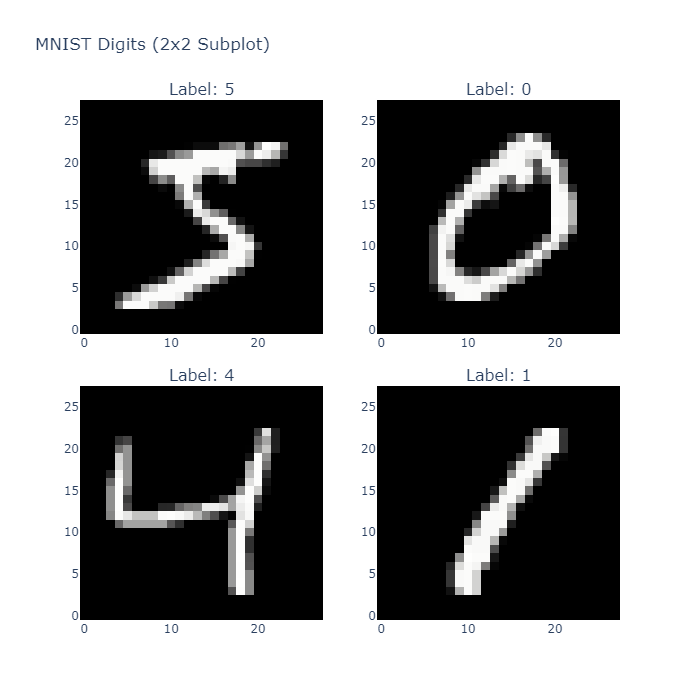

In [52]:
mnist = datasets.MNIST(root='./data', train=True, download=True)
images_ = [np.flipud(np.array(mnist[i][0])) for i in range(4)]
labels_ = [mnist[i][1] for i in range(4)]

# Create a 2x2 subplot
fig = make_subplots(rows=2, cols=2, subplot_titles=[f"Label: {label}" for label in labels_], vertical_spacing=0.1)

# Add each image to the subplot
plot_num = 0
for row in range(1, 3):
    for col in range(1, 3):
        fig.add_trace(
            go.Heatmap(z=images_[plot_num], showscale=False, colorscale='gray'),
            row=row, col=col
        )
        plot_num += 1

# Update layout for better appearance
fig.update_layout(height=700, width=700, title_text="MNIST Digits (2x2 Subplot)")

In [53]:
# Normalize the data
dataNorm = data / np.max(data)

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

___
### FFN Classifier

In [26]:
def createMnistNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)
            self.output = nn.Linear(32, 10)


        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.output(x)
            return torch.log_softmax(x, axis=1)
        

    net = mnistNet()
    lossfun = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfun, optimizer


def trainMinistNet(numepochs:int=60):
    net, lossfun, optimizer = createMnistNet()

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    for epochi in range(numepochs):
        net.train()
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)
        
        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        yHat = net(X)
        testAcc.append(100*torch.mean((torch.argmax(yHat, axis=1) == y).float()))
    
    return trainAcc, testAcc, losses, net

In [27]:
numepochs = 60
trainAcc, testAcc, losses, net = trainMinistNet(numepochs)

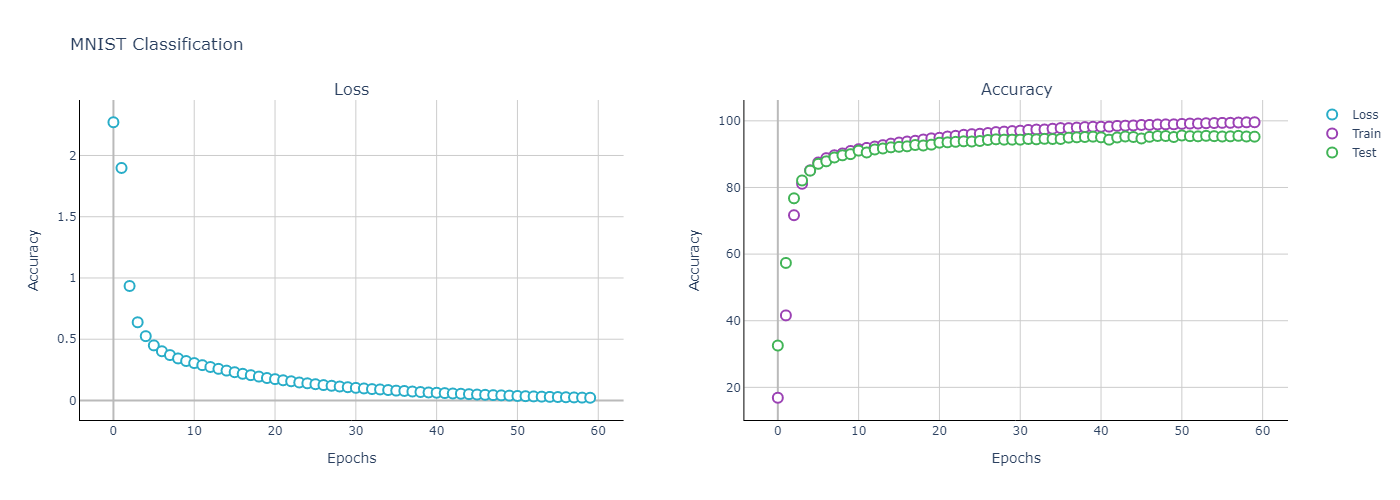

In [29]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Loss', 'Accuracy'])
fig.add_trace(go.Scatter(
    x=[i for i in range(numepochs)], y=losses, name='Loss',
    mode='markers', marker=dict(line=dict(color='#28adc8', width=2), color='white', size=10)
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=[i for i in range(numepochs)], y=trainAcc, name='Train',
    mode='markers', marker=dict(line=dict(color='#9b41b4', width=2), color='white', size=10)
), row=1, col=2)
fig.add_trace(go.Scatter(
    x=[i for i in range(numepochs)], y=testAcc, name='Test',
    mode='markers', marker=dict(line=dict(color='#41b456', width=2), color='white', size=10)
), row=1, col=2)
plotly_main_subplot_layout(fig, title='MNIST Classification', x='Epochs', y='Accuracy')

___
### Weights Visualization

In [35]:
print('Summary:')
print(f'{net}\n')

print('Weights:')
print(f'{net.input.weight}')

Summary:
mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

Weights:
Parameter containing:
tensor([[-0.0306,  0.0041, -0.0263,  ...,  0.0159, -0.0154,  0.0172],
        [-0.0122, -0.0166, -0.0017,  ..., -0.0071, -0.0115, -0.0181],
        [-0.0269,  0.0226,  0.0054,  ...,  0.0101,  0.0148, -0.0071],
        ...,
        [ 0.0150, -0.0238, -0.0315,  ..., -0.0278,  0.0312,  0.0011],
        [-0.0164,  0.0352,  0.0334,  ..., -0.0126,  0.0207,  0.0050],
        [-0.0247,  0.0080, -0.0005,  ...,  0.0033, -0.0172, -0.0051]],
       requires_grad=True)


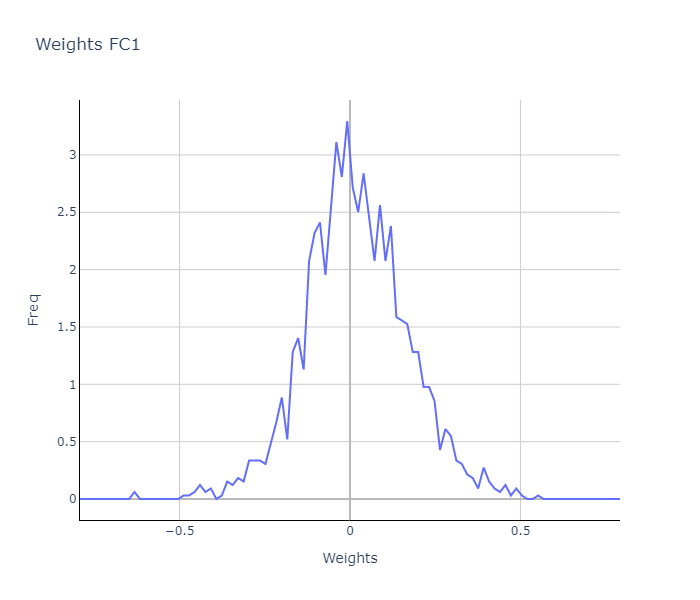

In [37]:
def weightsHist(net):
    W = np.array([])

    for layer in net.parameters():
        W = np.concatenate((W, net.fc1.weight.detach().flatten().numpy()))

    histy, histx = np.histogram(W, bins=np.linspace(-.8, .8, 101), density=True)
    histx = (histx[1:] + histx[:-1]) / 2
    return histx, histy

# Generate histogram data
histx, histy = weightsHist(net)

# Plot with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=histx, y=histy, mode='lines', name='Weight Histogram'))
plotly_main_layout(fig, title='Weights FC1', x='Weights', y='Freq')

In [45]:
def createMnistNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)
            self.output = nn.Linear(32, 10)


        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.output(x)
            return torch.log_softmax(x, axis=1)
        

    net = mnistNet()
    lossfun = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfun, optimizer


def trainMinistNet(numepochs:int=100):
    net, lossfun, optimizer = createMnistNet()

    histx = np.zeros((numepochs,100))
    histy = np.zeros((numepochs,100))

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    for epochi in range(numepochs):

        # Histogram
        histx, histy[epochi, :] = weightsHist(net)

        net.train()
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)
        
        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        yHat = net(X)
        testAcc.append(100*torch.mean((torch.argmax(yHat, axis=1) == y).float()))
    
    return trainAcc, testAcc, losses, net, histx, histy

numepochs = 100
trainAcc, testAcc, losses, net, histx, histy = trainMinistNet(numepochs)

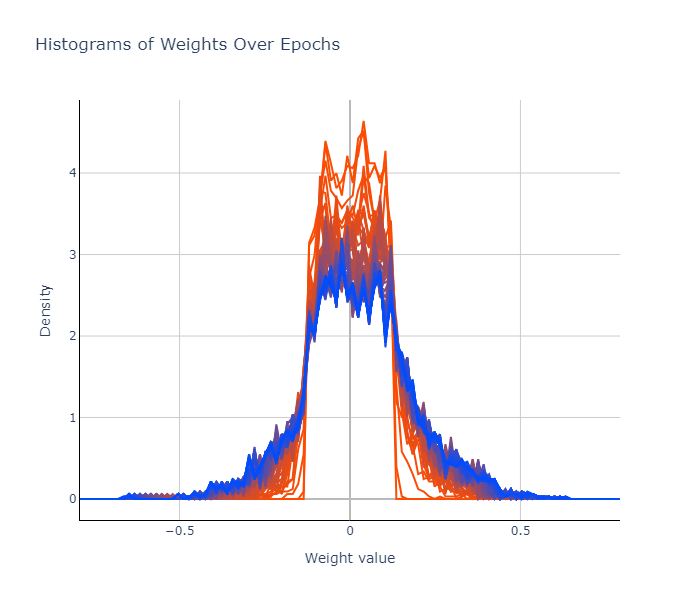

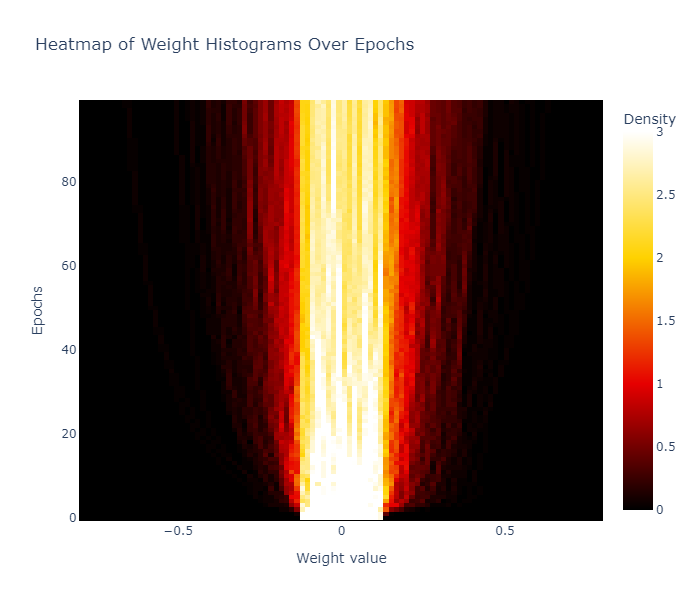

In [49]:
# Plot 1: Multiple histogram lines
fig1 = go.Figure()
for i in range(histy.shape[0]):
    color = f'rgb({int((1 - i/100) * 255)}, {int(0.3 * 255)}, {int((i/100) * 255)})'
    fig1.add_trace(go.Scatter(
        x=histx, y=histy[i, :], mode='lines', line=dict(color=color), name=f'Epoch {i}', showlegend=False
    ))
plotly_main_layout(fig1, title='Histograms of Weights Over Epochs', x='Weight value', y='Density')

# Plot 2: Heatmap of histograms
fig2 = go.Figure(data=go.Heatmap(
    z=histy, x=histx, y=np.arange(histy.shape[0]),
    colorscale='Hot', zmin=0, zmax=3, colorbar=dict(title='Density')
))
plotly_main_layout(fig2, title='Heatmap of Weight Histograms Over Epochs', x='Weight value', y='Epochs')

fig1.show()
fig2.show()

___
### Universal Approximation Theorem

- A sufficiently wide or deep nn can approximate any possible function (input-output mapping)
- $\underset{x,\theta}{\text{sup }} || f(x)-g_\theta (x) || < \epsilon$
    - $\text{sup}$: largest
    - $\theta$: parameters

___
### x

___
### x

___
### x

___
### x

___
### x

___
### x